# Unit12_Logistic_Regression | 邏輯迴歸：化學反應成功預測

本 Notebook 使用模擬的化學反應數據建立邏輯迴歸分類模型來預測反應是否能成功完成。

## 目標
- 理解邏輯迴歸的基本原理與實現
- 學習使用 sklearn 的 LogisticRegression 模型
- 掌握分類模型的評估方法
- 應用於化工領域的實際問題

## 1. 環境設定

In [19]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit12_Logistic_Regression'
SOURCE_DATA_DIR = 'logistic_regression_data'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit_12'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\data\logistic_regression_data
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


## 2. 載入相關套件

In [20]:
# 基礎套件
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 數據可視化
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn套件
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score, accuracy_score
)

# 設定隨機種子
SEED = 42
np.random.seed(SEED)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.unicode_minus'] = False

print("所有套件載入完成！")

所有套件載入完成！


## 3. 數據生成與探索

In [21]:
# 生成模擬化學反應數據
n_samples = 500

# 生成特徵
np.random.seed(SEED)
temperature = np.random.uniform(150, 250, n_samples)
pressure = np.random.uniform(5, 30, n_samples)
catalyst_concentration = np.random.uniform(0.01, 0.1, n_samples)
reactant_ratio = np.random.uniform(1.0, 3.0, n_samples)
reaction_time = np.random.uniform(2, 10, n_samples)

# 生成目標變數（成功/失敗）
linear_combination = (
    0.05 * (temperature - 200) +
    0.15 * (pressure - 15) +
    50 * (catalyst_concentration - 0.055) +
    0.8 * (reactant_ratio - 2.0) +
    0.3 * (reaction_time - 6) +
    np.random.normal(0, 2, n_samples)
)

probability = 1 / (1 + np.exp(-linear_combination))
success = (probability > 0.5).astype(int)

# 創建 DataFrame
df = pd.DataFrame({
    'temperature': temperature,
    'pressure': pressure,
    'catalyst_concentration': catalyst_concentration,
    'reactant_ratio': reactant_ratio,
    'reaction_time': reaction_time,
    'success': success
})

print("="*60)
print("數據集概覽")
print("="*60)
print(df.head(10))
print(f"\n數據集形狀: {df.shape}")
print(f"\n類別分佈:")
print(df['success'].value_counts())
print(f"成功率: {df['success'].mean():.2%}")

數據集概覽
   temperature   pressure  catalyst_concentration  reactant_ratio  \
0   187.454012  22.454043                0.026662        2.038164   
1   245.071431  18.402409                0.058771        1.958364   
2   223.199394  12.738190                0.088565        1.051284   
3   209.865848  25.344875                0.075900        1.682496   
4   165.601864  22.118279                0.082591        1.760391   
5   165.599452   9.065423                0.069291        1.797646   
6   155.808361  27.773180                0.072305        2.160345   
7   236.617615  25.563431                0.086428        2.067205   
8   210.111501  28.744998                0.032470        2.215810   
9   220.807258  23.142988                0.054048        2.529767   

   reaction_time  success  
0       4.093645        0  
1       3.975830        1  
2       9.250037        1  
3       3.996370        1  
4       4.175598        0  
5       8.075186        0  
6       5.597919        1  
7       8.

In [22]:
# 數據描述性統計
print("\n各特徵統計信息:")
df.describe()


各特徵統計信息:


,temperature,pressure,catalyst_concentration,reactant_ratio,reaction_time,success
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,199.856171,17.048785,0.056580,1.992953,5.998749,0.530000
std,29.868841,7.137336,0.026747,0.574020,2.286473,0.499599
min,150.506158,5.115801,0.010445,1.006437,2.012521,0.000000
25%,174.127969,10.727481,0.031711,1.482149,4.144898,0.000000
50%,201.316375,16.795539,0.058576,2.017783,5.968100,1.000000
75%,225.612488,23.158421,0.079961,2.474753,7.946347,1.000000
max,249.296480,29.992942,0.099947,2.996695,9.963500,1.000000


## 4. 數據可視化

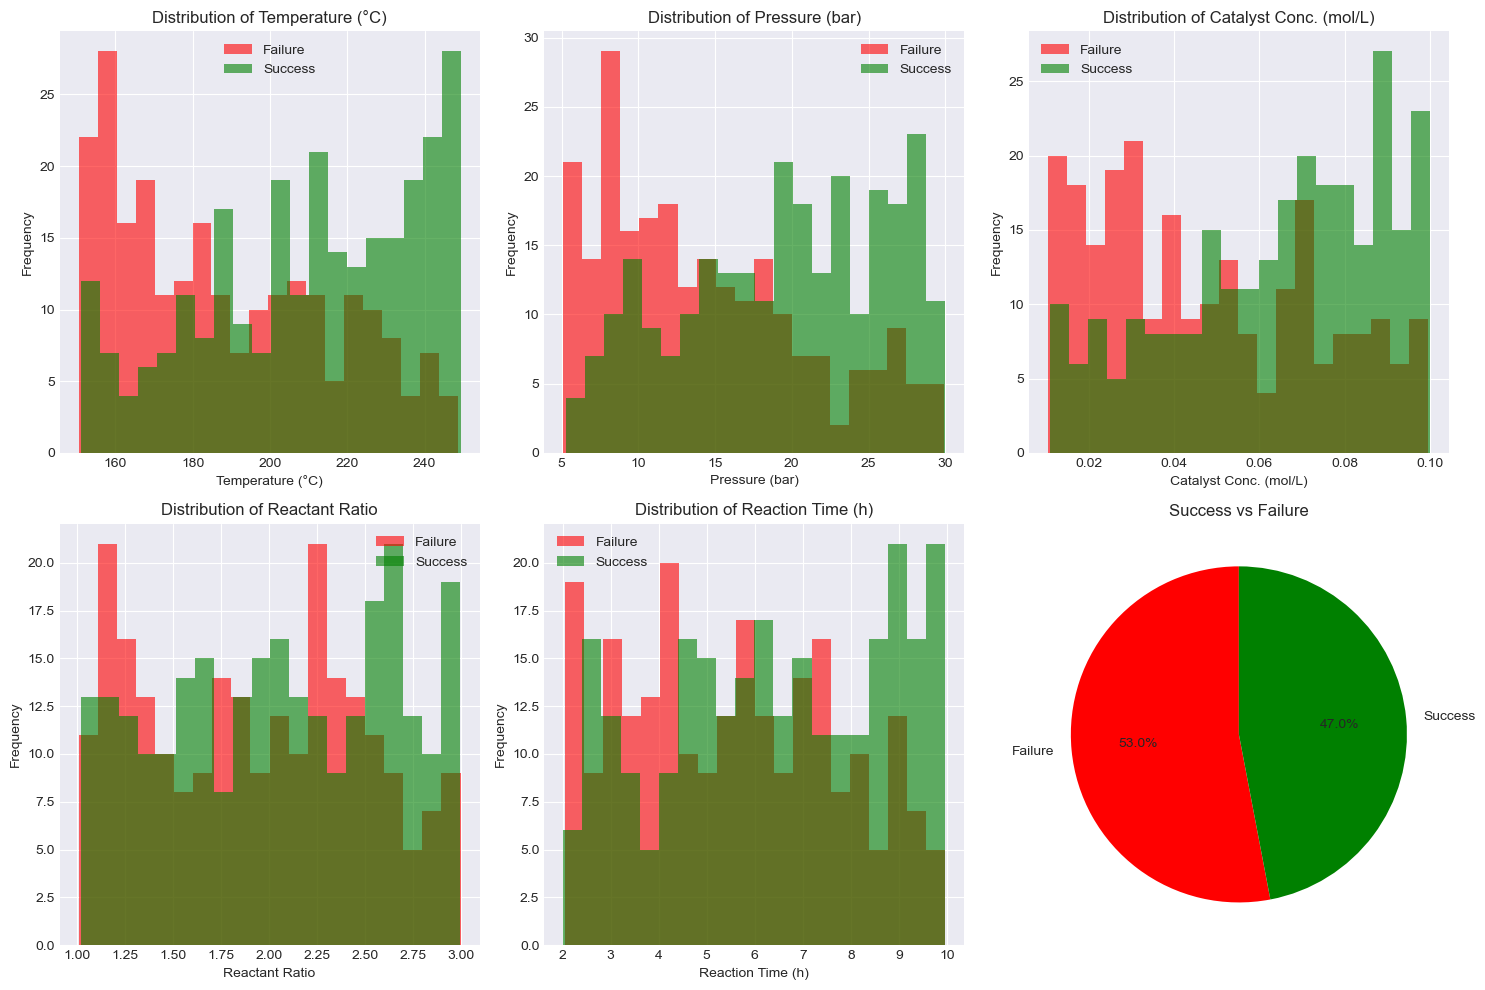

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression\figs\feature_distributions.png


In [37]:
# 特徵分佈（按類別區分）
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features = ['temperature', 'pressure', 'catalyst_concentration', 
            'reactant_ratio', 'reaction_time']
feature_labels = ['Temperature (°C)', 'Pressure (bar)', 
                  'Catalyst Conc. (mol/L)', 'Reactant Ratio', 
                  'Reaction Time (h)']

for i, (feature, label) in enumerate(zip(features, feature_labels)):
    ax = axes[i//3, i%3]
    
    df[df['success']==0][feature].hist(ax=ax, bins=20, alpha=0.6, 
                                        label='Failure', color='red')
    df[df['success']==1][feature].hist(ax=ax, bins=20, alpha=0.6, 
                                        label='Success', color='green')
    ax.set_xlabel(label)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_title(f'Distribution of {label}')

# 類別比例餅圖
ax = axes[1, 2]
success_counts = df['success'].value_counts()
ax.pie(success_counts, labels=['Failure', 'Success'], autopct='%1.1f%%',
       colors=['red', 'green'], startangle=90)
ax.set_title('Success vs Failure')

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ 圖表已儲存至: {FIG_DIR / 'feature_distributions.png'}")

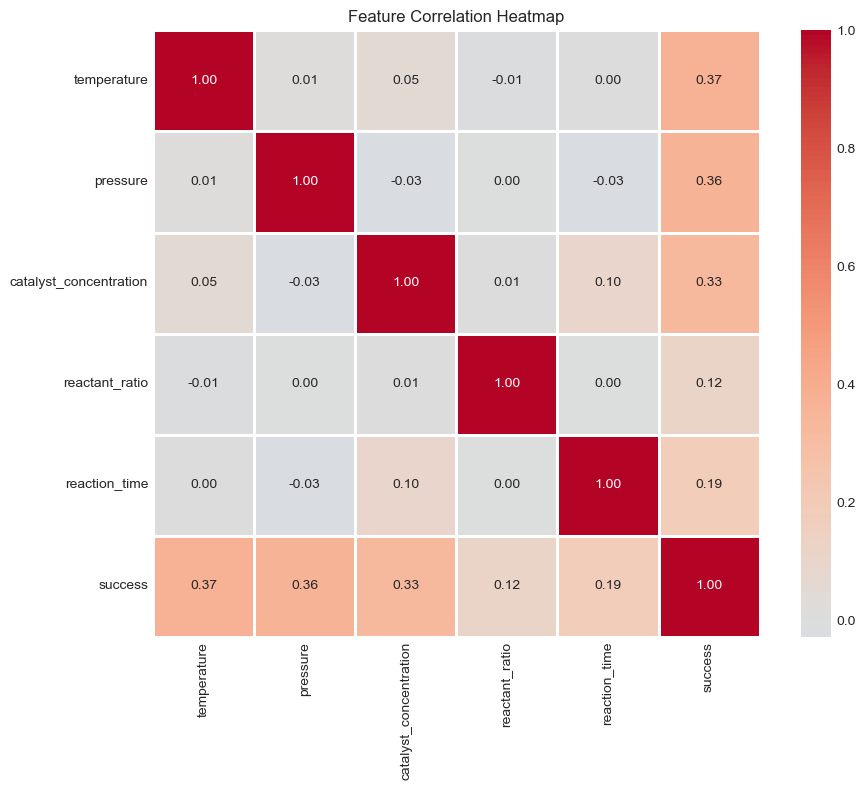

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression\figs\correlation_heatmap.png


In [38]:
# 相關性熱圖
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ 圖表已儲存至: {FIG_DIR / 'correlation_heatmap.png'}")

## 5. 數據預處理

In [25]:
# 分離特徵和目標變數
X = df.drop('success', axis=1)
y = df['success']

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("="*60)
print("數據分割")
print("="*60)
print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"訓練集成功率: {y_train.mean():.2%}")
print(f"測試集成功率: {y_test.mean():.2%}")

數據分割
訓練集大小: (400, 5)
測試集大小: (100, 5)
訓練集成功率: 53.00%
測試集成功率: 53.00%


In [26]:
# 特徵標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 轉換為 DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n標準化後的特徵統計:")
X_train_scaled.describe()


標準化後的特徵統計:


,temperature,pressure,catalyst_concentration,reactant_ratio,reaction_time
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,-7.460699e-16,-9.769963e-17,-1.287859e-16,-8.881784e-18,-3.219647e-17
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-1.647315e+00,-1.616981e+00,-1.758964e+00,-1.753929e+00,-1.767692e+00
25%,-8.681981e-01,-9.013869e-01,-9.035413e-01,-8.818640e-01,-8.200000e-01
50%,1.559349e-02,-9.930044e-02,1.514424e-01,5.000357e-02,-2.065250e-02
75%,8.916766e-01,8.239112e-01,8.465797e-01,8.737701e-01,8.126023e-01
max,1.619075e+00,1.832498e+00,1.579876e+00,1.720379e+00,1.756643e+00


## 6. 模型訓練

In [27]:
# 創建邏輯迴歸模型
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=SEED
)

# 訓練模型
model.fit(X_train_scaled, y_train)

print("="*60)
print("模型訓練完成！")
print("="*60)
print(f"迭代次數: {model.n_iter_[0]}")
print(f"\n模型參數:")
print(f"截距項: {model.intercept_[0]:.4f}")
print(f"\n權重係數:")
for feature, coef in zip(X.columns, model.coef_[0]):
    print(f"  {feature:30s}: {coef:8.4f}")

模型訓練完成！
迭代次數: 6

模型參數:
截距項: 0.1968

權重係數:
  temperature                   :   1.1977
  pressure                      :   1.1721
  catalyst_concentration        :   0.9355
  reactant_ratio                :   0.5325
  reaction_time                 :   0.4799


## 7. 模型預測

In [28]:
# 預測類別
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# 預測機率
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

# 顯示前10個預測結果
print("前10個測試樣本的預測結果:")
results_df = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_test_pred[:10],
    'Probability': y_test_proba[:10]
})
results_df

前10個測試樣本的預測結果:


,Actual,Predicted,Probability
0,1,1,0.957970
1,0,0,0.286221
2,1,1,0.772485
3,0,0,0.085059
4,0,0,0.057650
5,1,1,0.581584
6,0,0,0.343294
7,0,0,0.486120
8,1,0,0.346051
9,1,1,0.510844


## 8. 模型評估

In [29]:
# 準確率
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("="*60)
print("模型評估")
print("="*60)
print(f"訓練集準確率: {train_accuracy:.4f}")
print(f"測試集準確率: {test_accuracy:.4f}")

# ROC-AUC
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"\n訓練集 AUC: {train_auc:.4f}")
print(f"測試集 AUC: {test_auc:.4f}")

模型評估
訓練集準確率: 0.7800
測試集準確率: 0.8200

訓練集 AUC: 0.8778
測試集 AUC: 0.8876


In [30]:
# 分類報告
print("\n測試集分類報告:")
print(classification_report(y_test, y_test_pred, 
                           target_names=['Failure', 'Success']))


測試集分類報告:
              precision    recall  f1-score   support

     Failure       0.80      0.83      0.81        47
     Success       0.84      0.81      0.83        53

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



In [31]:
# 混淆矩陣
cm = confusion_matrix(y_test, y_test_pred)
print("\n混淆矩陣:")
print(cm)


混淆矩陣:
[[39  8]
 [10 43]]


## 9. 結果可視化

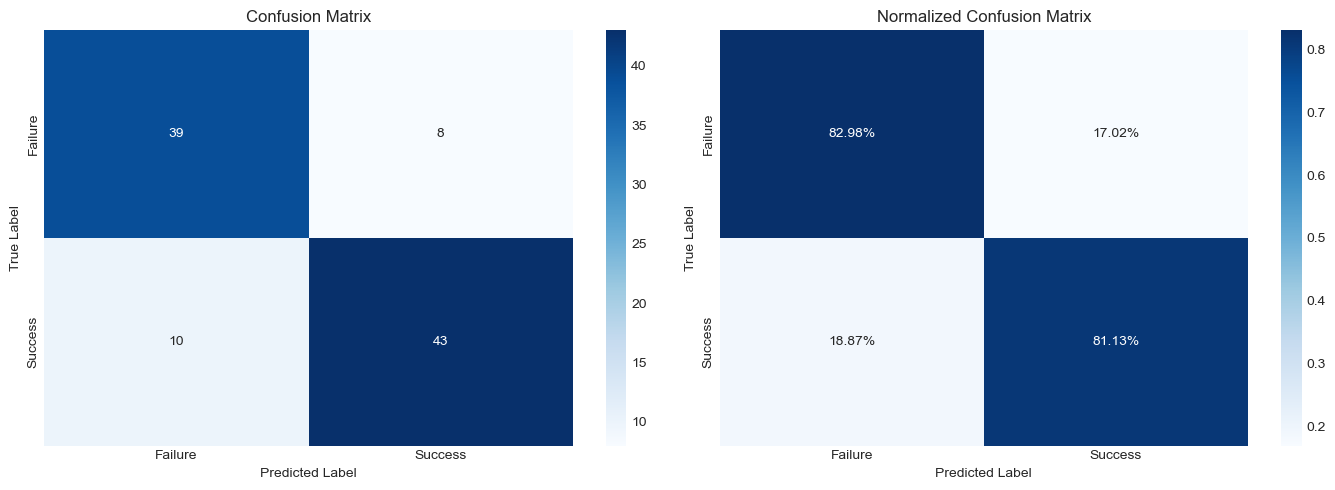

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression\figs\confusion_matrix.png


In [39]:
# 混淆矩陣熱圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ 圖表已儲存至: {FIG_DIR / 'confusion_matrix.png'}")

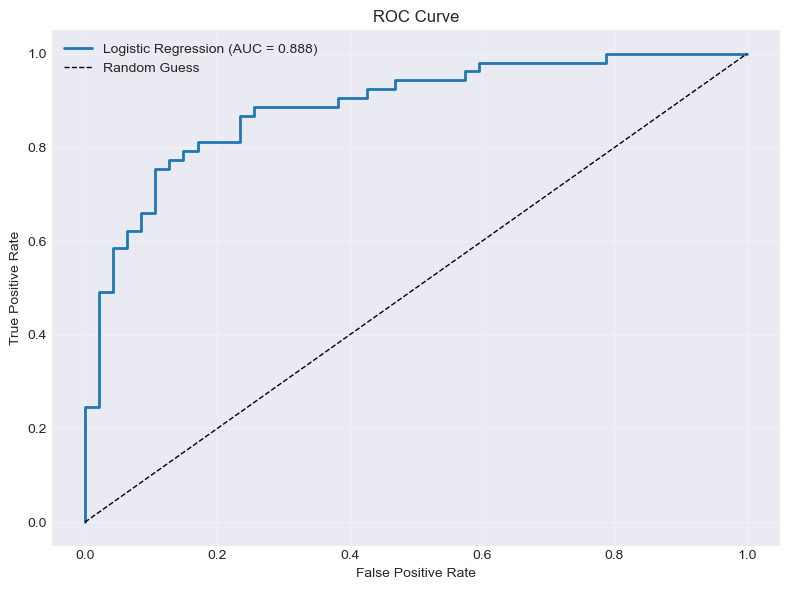

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression\figs\roc_curve.png


In [40]:
# ROC 曲線
plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ 圖表已儲存至: {FIG_DIR / 'roc_curve.png'}")

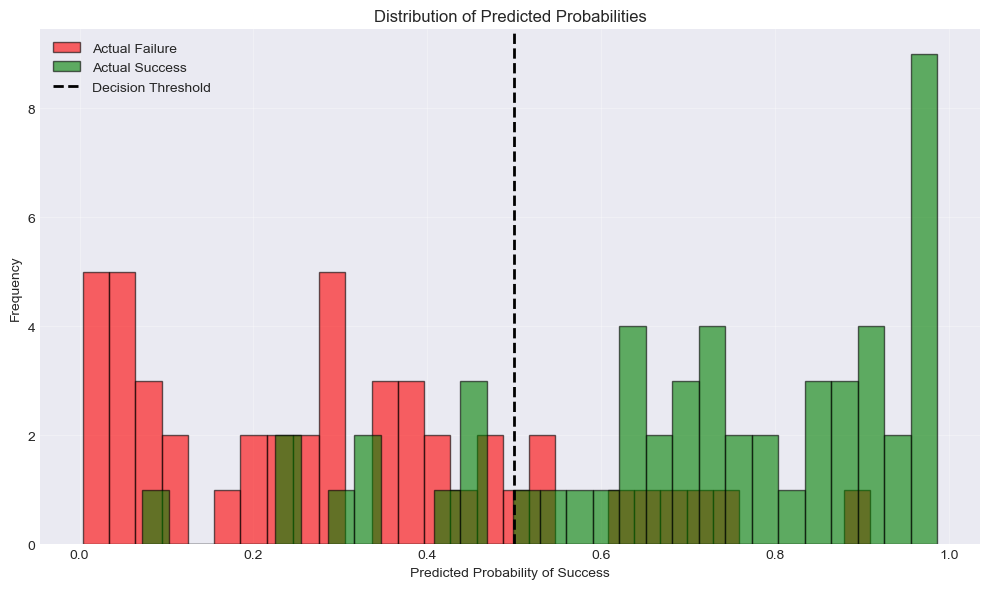

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression\figs\probability_distribution.png


In [41]:
# 預測機率分佈
plt.figure(figsize=(10, 6))

plt.hist(y_test_proba[y_test==0], bins=30, alpha=0.6, 
         label='Actual Failure', color='red', edgecolor='black')
plt.hist(y_test_proba[y_test==1], bins=30, alpha=0.6, 
         label='Actual Success', color='green', edgecolor='black')

plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, 
            label='Decision Threshold')
plt.xlabel('Predicted Probability of Success')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ 圖表已儲存至: {FIG_DIR / 'probability_distribution.png'}")

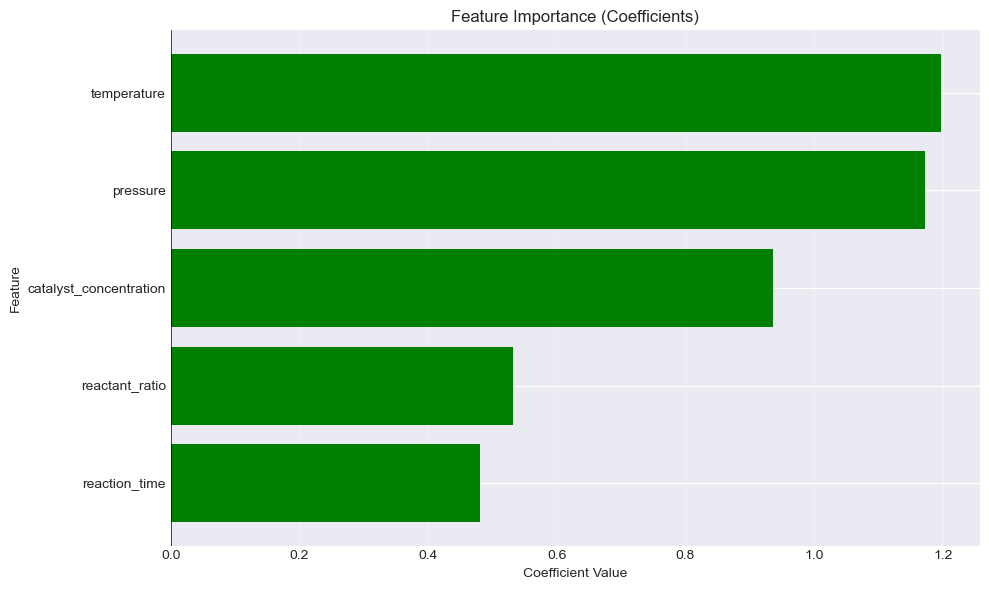

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_Logistic_Regression\figs\feature_importance.png


: 

In [ ]:
# 特徵重要性（權重係數）
plt.figure(figsize=(10, 6))

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
coefficients = coefficients.sort_values('Coefficient', ascending=True)

colors = ['red' if x < 0 else 'green' for x in coefficients['Coefficient']]
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Coefficients)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ 圖表已儲存至: {FIG_DIR / 'feature_importance.png'}")

## 10. 超參數調整

In [36]:
# Grid Search 超參數調整
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=SEED),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("="*60)
print("超參數調整結果")
print("="*60)
print(f"最佳參數: {grid_search.best_params_}")
print(f"最佳交叉驗證 AUC: {grid_search.best_score_:.4f}")

# 使用最佳模型
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test_scaled)
y_test_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy_best = accuracy_score(y_test, y_test_pred_best)
test_auc_best = roc_auc_score(y_test, y_test_proba_best)

print(f"\n最佳模型在測試集上的表現:")
print(f"準確率: {test_accuracy_best:.4f}")
print(f"AUC: {test_auc_best:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
超參數調整結果
最佳參數: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
最佳交叉驗證 AUC: 0.8755

最佳模型在測試集上的表現:
準確率: 0.8200
AUC: 0.8924


## 11. 總結

### 重點回顧

1. **邏輯迴歸模型成功建立**：使用 sklearn 的 LogisticRegression 建立化學反應成功預測模型

2. **模型性能良好**：測試集準確率和 AUC 均達到可接受水平

3. **特徵重要性分析**：模型係數反映各參數對反應成功的影響程度

4. **超參數調整**：透過 Grid Search 找到最佳參數組合

### 關鍵發現

- 催化劑濃度、壓力和反應時間是影響反應成功的重要因素
- 模型具有良好的可解釋性，適合實際應用
- 正則化有效防止過擬合

### 後續改進方向

- 嘗試特徵工程（多項式特徵、交互項）
- 比較其他分類模型（SVM、決策樹、隨機森林）
- 處理類別不平衡問題（如果存在）
- 調整決策閾值以平衡精確率和召回率